# Application: A Vehicle Detection Pipeline



* In this section, we will take a look at one such feature extraction technique, the [Histogram of Oriented Gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) (HOG), which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination.
We will use these features to develop a simple vehicle detection pipeline, using machine learning algorithms .

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## HOG Features

* The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying vehicles within images.




In [3]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

### **READING ALL VEHICLE IMAGES AND CONVERTING ALL OF THEM TO GRAYSCALE** : 
* **GTI_Far :** contains all the zoomed version of vehicles that are far.
* **GTI_Left :** contains all the left and zoomed version of vehicles that are far.
* **GTI_Right :** contains all the right and zoomed version of vehicles that are far.
* **GTI_MiddleClose :** contains all the middle and zoomed version of vehicles that are far.
* **KITTI_extracted :** contains images extracted from publically available kitty dataset , these images contains distinguished orientations.

In [5]:
GTI_farcars=np.array(load_images_from_folder('/content/drive/MyDrive/vehicles/GTI_Far'))
GTI_leftcars=np.array(load_images_from_folder('/content/drive/MyDrive/vehicles/GTI_Left'))
GTI_middlecars=np.array(load_images_from_folder('/content/drive/MyDrive/vehicles/GTI_MiddleClose'))
GTI_rightcars=np.array(load_images_from_folder('/content/drive/MyDrive/vehicles/GTI_Right'))
kitticars=np.array(load_images_from_folder('/content/drive/MyDrive/vehicles/KITTI_extracted'))

* **ADDING ALL THE IMAGES ONE AFTER OTHER IN CARS_ARRAY AND THIS WILL CONSTITUTE TO POSITIVE EXAMPLES FOR LINEAR SVC.**

In [6]:
cars_array=np.array(np.zeros((8792,64,64,3)))
cars_array[:834]=GTI_farcars[:]
cars_array[834:834+909]=GTI_leftcars[:]
cars_array[834+909:834+909+419]=GTI_middlecars[:]
cars_array[834+909+419:834+909+419+664]=GTI_rightcars[:]
cars_array[834+909+419+664:834+909+419+664+5966]=kitticars[:]

* **Converting all the Color Images to GrayScale.**

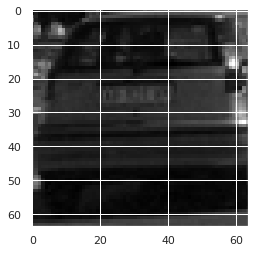

In [7]:
from skimage.color import rgb2gray
grayscale=np.array(np.zeros((8792,64,64)))
grayscale[:] = rgb2gray(cars_array[:])
plt.imshow(grayscale[1000],cmap='gray')

* **Visualization of HOG features.**

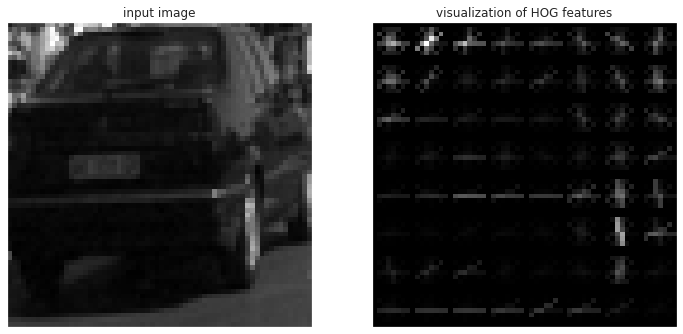

In [29]:
from skimage import data, color, feature , transform
hog_vec, hog_vis = feature.hog(grayscale[1010], visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(grayscale[1010], cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis,cmap='gray')
ax[1].set_title('visualization of HOG features');

## HOG in Action: A Simple Vehicle Detector

Using these HOG features, we can build up a simple Vehicle detection algorithm with any Scikit-Learn estimator; here we will use a linear support vector machine.
The steps are as follows:

1. Obtain a set of image thumbnails of Vehicles to constitute "positive" training samples.
2. Obtain a set of image thumbnails of non-Vehicles to constitute "negative" training samples.
3. Extract HOG features from these training samples.
4. Train a linear SVM classifier on these samples.
5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a Vehicle or not.
6. If detections overlap, combine them into a single window.

Let's go through these steps and try it out:

### 1. Obtain a set of positive training samples

Let's start by finding some positive training samples that show a variety of Vehicles extracted using KITTI dataset.

In [10]:
positive_patches = grayscale
positive_patches.shape

(8792, 64, 64)

This gives us a sample of 8792 vehicle images to use for training.

### 2. Obtain a set of negative training samples

Next we need a set of similarly sized thumbnails which *do not* have a Vehicle in them.


In [11]:
notcars_array=np.array(np.zeros((8978,64,64,3)))
GTI=np.array(load_images_from_folder('/content/drive/MyDrive/non-vehicles/GTI'))
extras=np.array(load_images_from_folder('/content/drive/MyDrive/non-vehicles/Extras'))

In [12]:
print(len(GTI)+len(extras))

8978


In [13]:
notcars_array[:3900]=GTI[:]
notcars_array[3900:3900+5078]=extras[:]
notgrayscale=np.array(np.zeros((8978,64,64)))
notgrayscale[:] = rgb2gray(notcars_array[:])

In [14]:
negative_patches=np.array(np.zeros((8978,64,64)))
negative_patches[:]=notgrayscale[:]
negative_patches.shape

(8978, 64, 64)

We now have 8978 suitable image patches which do not contain vehicles.
Let's take a look at a few of them to get an idea of what they look like:

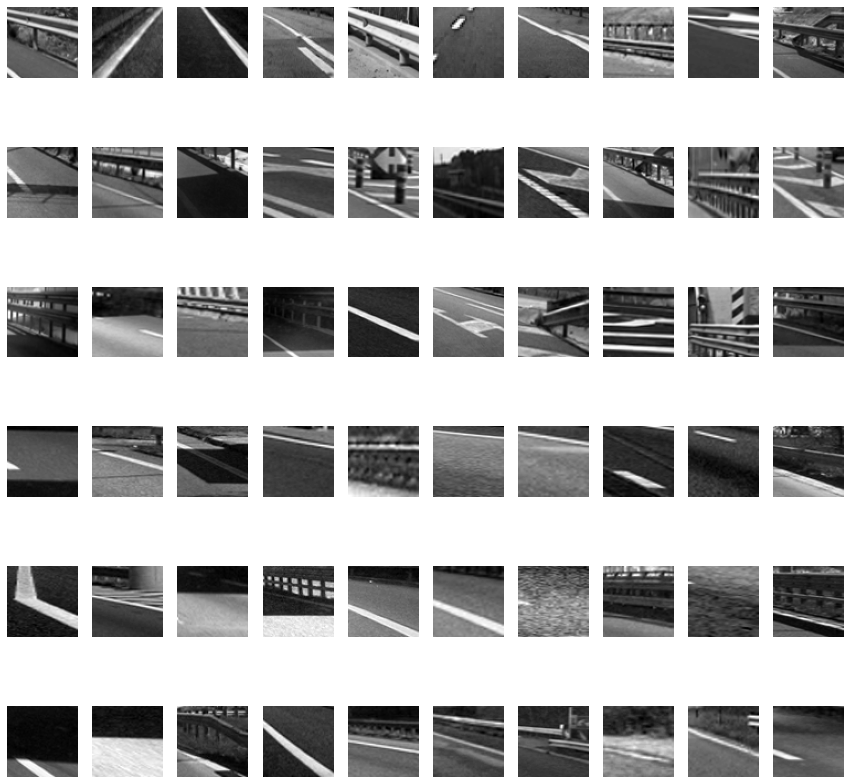

In [18]:
fig, ax = plt.subplots(6, 10,figsize=(15,15))
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[ 10*i], cmap='gray')
    axi.axis('off')

Our hope is that these would sufficiently cover the space of "non-vehicles" that our algorithm is likely to see.

### 3. Combine sets and extract HOG features

* Now that we have these positive samples and negative samples, we can combine them and compute HOG features:

In [19]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [20]:
X_train.shape

(17770, 2916)

* We are left with 17770 training samples in 2916 dimensions, and we now have our data in a form that we can feed into Scikit-Learn!

### 4. Training a support vector machine

Next we use the tools we have been exploring in this chapter to create a classifier of thumbnail patches.
For such a high-dimensional binary classification task, a Linear support vector machine is a good choice.
We will use Scikit-Learn's ``LinearSVC``, because in comparison to ``SVC`` it often has better scaling for large number of samples.

First, though, let's use a simple Gaussian naive Bayes to get a quick baseline:

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.8849184 , 0.82611142, 0.74704558, 0.75576815, 0.91868317])

* We see that on our training data, even a simple naive Bayes algorithm gets us fair accuracy.
Let's try the support vector machine, with a grid search over a few choices of the C parameter:

In [22]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(max_iter=5000), {'C': [1.0, 2.0, 4.0, 8.0]})
# grid = GridSearchCV(LinearSVC(), {'C': [0.2, 0.4, 0.6, 0.8]})
grid.fit(X_train, y_train)
grid.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

0.9393922341024197

In [23]:
grid.best_params_

{'C': 1.0}

Let's take the best estimator and re-train it on the full dataset:

In [24]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### 5. Find vehicles in a new image

* Now that we have this model in place, let's grab a new image and see how the model does.


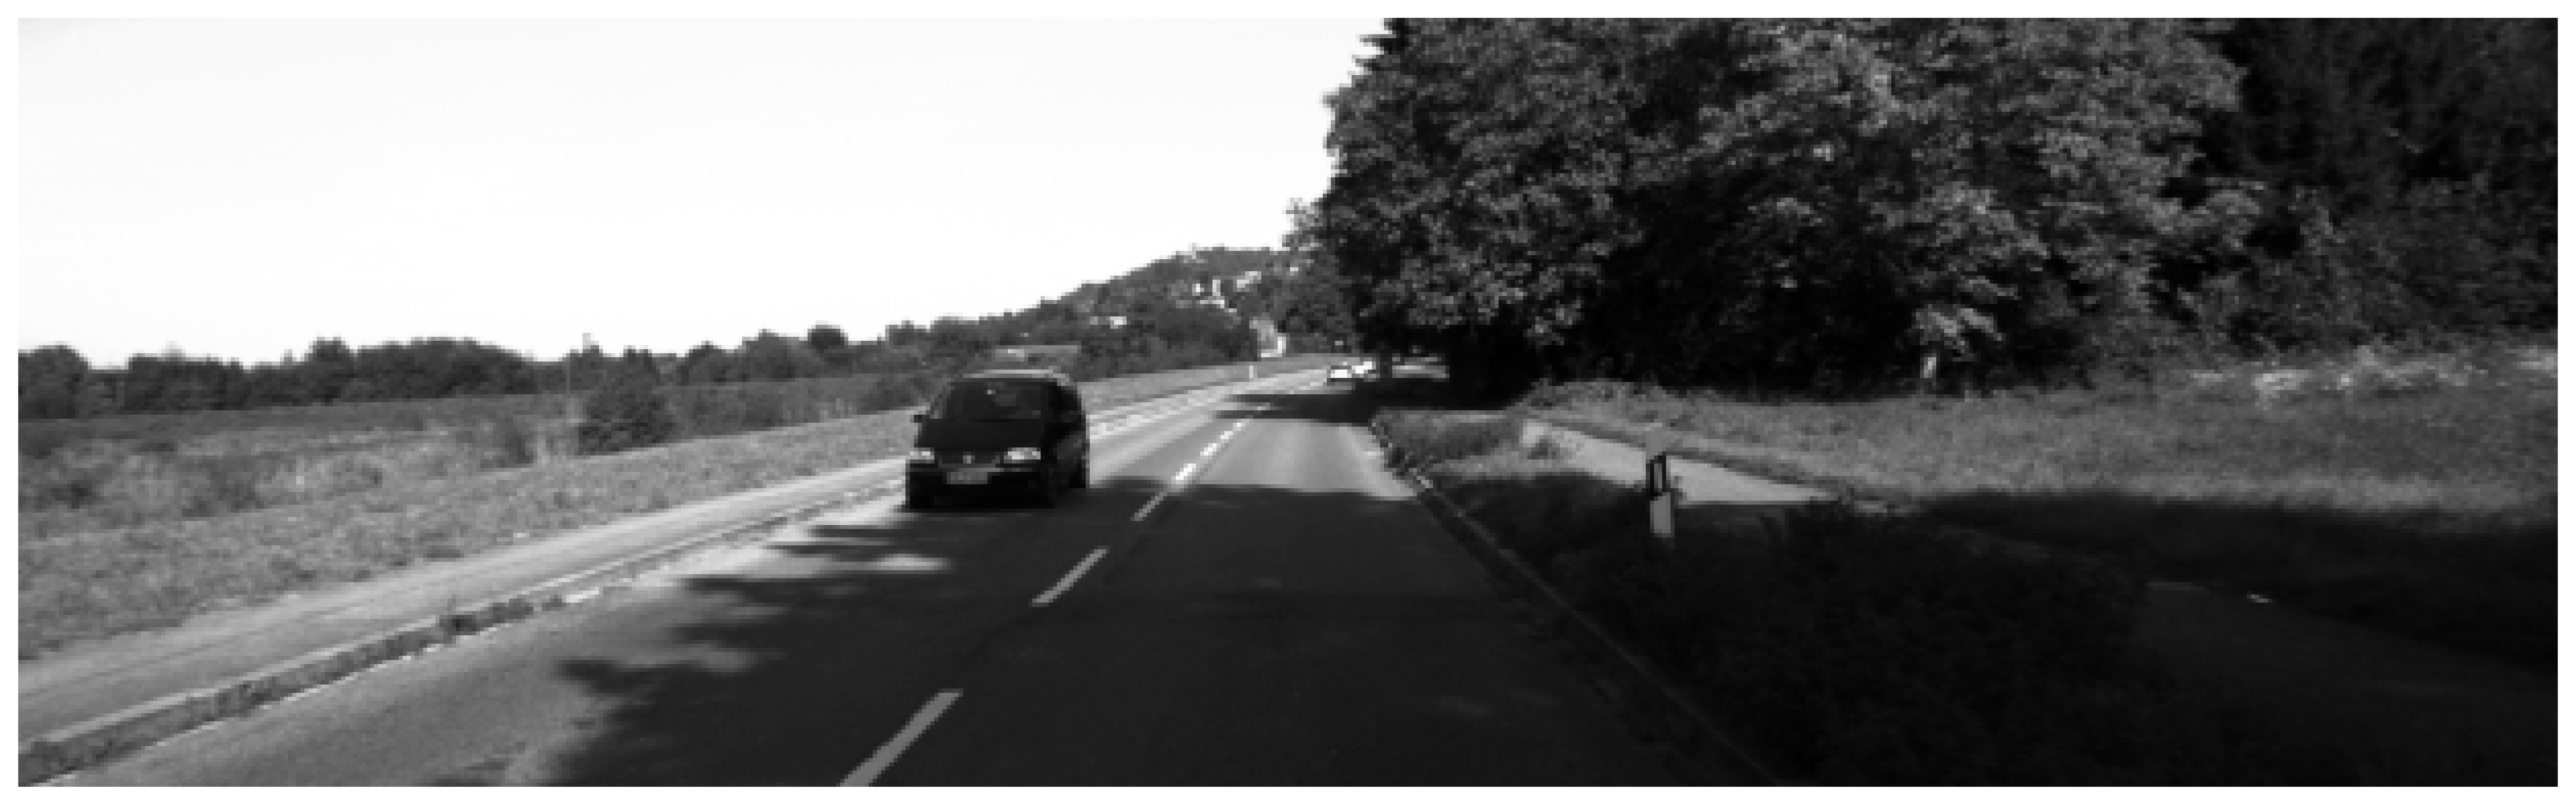

In [30]:
import cv2
from matplotlib.pyplot import figure
from skimage import transform
test_image = cv2.imread('/content/drive/MyDrive/kitti_single_fold/testing/image_2/000019.png')

test_image = rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.5)
test_image = test_image[:, :]


figure(num=None, figsize=(18, 10), dpi=500, facecolor='w', edgecolor='k')
plt.imshow(test_image, cmap='gray')
plt.axis('off');

* Next, let's create a window that iterates over patches of this image, and compute HOG features for each patch:

In [31]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=5, jstep=5, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(2800, 2916)

* Finally, we can take these HOG-featured patches and use our model to evaluate whether each patch contains a vehicle:

In [32]:
labels = model.predict(patches_hog)
labels.sum()

58.0

* Visualisation of Vehicles in the image represented by red Rectangles.

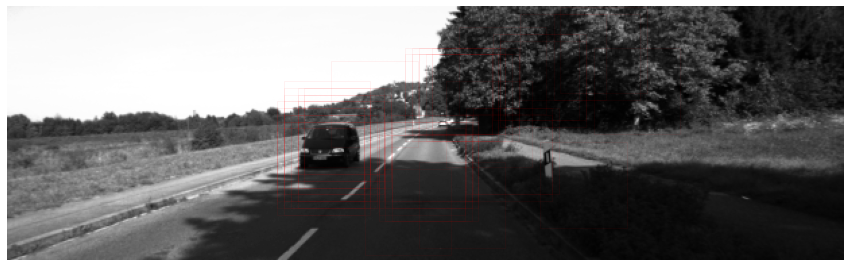

In [33]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.1, lw=0.5, facecolor='none'))

**All of the detected patches overlap and found the Vehicle in the image!**


---




